In [1]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


--2021-05-29 21:37:34--  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
Resolving mtg.upf.edu (mtg.upf.edu)... 84.89.139.55
Connecting to mtg.upf.edu (mtg.upf.edu)|84.89.139.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672741554 (642M) [application/x-gzip]
Saving to: ‘lastfm-dataset-1K.tar.gz’

lastfm-dataset-1K.t 100%[===================>] 641.58M  1.26MB/s    in 10m 46s 

2021-05-29 21:48:20 (1017 KB/s) - ‘lastfm-dataset-1K.tar.gz’ saved [672741554/672741554]

lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv


In [2]:
!ls

lastfm-dataset-1K  lastfm-dataset-1K.tar.gz  sample_data


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/data

feature_df_with_emb.csv  spotify_features.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [6]:
path = "drive/MyDrive/data/feature_df_with_emb.csv"

feature_df_with_emb = pd.read_csv(path)

In [7]:
feature_df_with_emb.head()

,Unnamed: 0,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
0,0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794,0.1130,0.5290,105.089,330253.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
1,1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916,0.1140,0.2700,137.802,540133.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
2,2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939,0.1010,0.0703,73.926,216853.0,"['japanese indie folk', 'japanese soundtrack',...",39,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
3,3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859,0.0866,0.0376,80.714,384707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
4,4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898,0.1030,0.0920,104.191,580707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493


In [8]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [9]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [10]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [11]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [12]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [13]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [14]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [15]:
df = df.set_index('song-id')

In [16]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [17]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [18]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [19]:
matrix_init = matrix_init['timestamp']
matrix_init = matrix_init.map(lambda x: np.log(x))

In [20]:
matrix_init = matrix_init.reset_index()

In [21]:
def rating_scaler(row):
    row_array = np.array(row)
    a, new_range= 1, 4
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + a
    return pd.Series(scaled_row)

In [22]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [23]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [24]:
feature_df_with_emb.head()
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[1]+'-'+row[2], axis=1)

### Merge data

In [25]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

In [26]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [27]:
matrix_extended.head()

,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,1.652605,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
1,user_000451,2562,Basin Dub,1.617691,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
2,user_000471,2562,Basin Dub,1.000000,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
3,user_000508,2562,Basin Dub,2.129150,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
4,user_000515,2562,Basin Dub,1.556342,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub


### Filter the dataset

In [28]:
matrix_extended.groupby('user').count()['rating'].describe()

count      992.000000
mean      4367.426411
std       5152.289753
min          1.000000
25%       1265.500000
50%       2945.000000
75%       5524.500000
max      65246.000000
Name: rating, dtype: float64

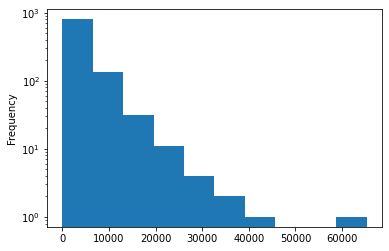

In [29]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [30]:
matrix_extended.groupby('item').count()['rating'].describe()

count    929536.000000
mean          4.660914
std          10.819621
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

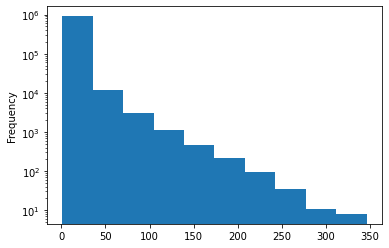

In [31]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

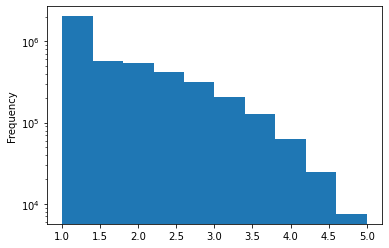

In [50]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [33]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [34]:
matrix_sampled.groupby('user').count()['rating'].describe()

count      991.000000
mean      3399.972755
std       3809.005245
min          3.000000
25%       1064.500000
50%       2344.000000
75%       4265.000000
max      47788.000000
Name: rating, dtype: float64

### Sample Users

In [35]:
# no_users = 200
# users_list = matrix_extended.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled = matrix_extended.copy()
# matrix_sampled = matrix_sampled.set_index('user')
# matrix_sampled = matrix_sampled.loc[users_sampled]
# matrix_sampled = matrix_sampled.reset_index()
# matrix_sampled = matrix_sampled.sample(frac=1)
# matrix_sampled['item'] = matrix_sampled.apply(lambda row: row[1]+'-'+row[2], axis=1)

In [36]:
matrix_sampled.head()

,item,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
1525460,Ladytron-Kletva,user_000215,Ladytron,Kletva,1.0,19905,0.452,0.789,2.0,-4.413,1.0,0.0344,0.002330,0.224000,0.5440,0.2520,97.477,162693.0,"['electroclash', 'alternative dance', 'new rav...",58,[5.9564935 7.30105835 2.5005095 ],5.956494,7.301058,2.500510
3146017,Tiger Trap-Supreme Nothing,user_000670,Tiger Trap,Supreme Nothing,1.0,260319,0.441,0.843,7.0,-6.687,1.0,0.0401,0.001460,0.815000,0.0968,0.6120,136.389,131933.0,"['riot grrrl', 'twee pop', 'tape club', 'sacra...",29,[6.0325904 8.323377 1.8079653],6.032590,8.323377,1.807965
426028,Boom Bip & Doseone-Fence Hopping,user_000397,Boom Bip & Doseone,Fence Hopping,1.0,355214,0.389,0.759,11.0,-21.935,0.0,0.8230,0.486000,0.116000,0.3740,0.0792,84.911,95627.0,"['abstract hip hop', 'psychedelic hip hop', 'i...",29,[4.2508288 7.48125465 4.22295815],4.250829,7.481255,4.222958
1948867,Nine Inch Nails-Big Man With A Gun,user_000082,Nine Inch Nails,Big Man With A Gun,1.0,37728,0.336,0.985,9.0,-4.023,1.0,0.1100,0.000252,0.068000,0.8110,0.3800,199.865,96200.0,"['cyberpunk', 'rock', 'alternative metal', 'in...",71,[7.2162992 7.7143175 1.3324544],7.216299,7.714317,1.332454
510925,Cannonball Adderley-Limehouse Blues,user_000012,Cannonball Adderley,Limehouse Blues,1.0,38231,0.422,0.506,9.0,-12.187,0.0,0.0498,0.728000,0.000062,0.0945,0.6990,160.672,280227.0,"['hard bop', 'jazz', 'jazz funk', 'soul jazz',...",37,[3.7134242 5.6224515 0.38689909],3.713424,5.622452,0.386899


In [37]:
matrix_sampled['user_id'] = matrix_sampled['user'].astype('category').cat.codes
matrix_sampled['item_id'] = matrix_sampled['item'].astype('category').cat.codes

In [38]:
X = matrix_sampled[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled['rating']
groups = matrix_sampled['user_id']

In [39]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [40]:
no_users, no_items, no_factors = matrix_sampled['user_id'].nunique(), matrix_sampled['item_id'].nunique(), 100

In [41]:
no_users

991

In [42]:
no_items

246166

### Models

In [43]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [44]:
model = create_shallow_model(no_factors, no_users, no_items)

In [45]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       99200       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       24616700    item_id[0][0]                    
______________________________________________________________________________________

In [92]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(64,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(32,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(16,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(8,name='fc6', activation='relu')(dropout_3)
    dense_4_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_4)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_4_output], name='deep_model')
    return model

In [93]:
model = create_deep_model(no_factors, no_users, no_items)

### Model training

In [ ]:
# Input-output data definition
X_train_arr = [X_train.user_id, X_train.item_id]

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError())

# Model training
model.fit(X_train_arr, y_train, epochs=10, batch_size=2048, shuffle=True)

Epoch 1/10
1274/1317 [============================>.] - ETA: 4s - loss: 0.7005

### Prediction

In [52]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train_arr, batch_size=2048)

In [53]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
2422236,425,180479,0.119,0.0588,0.0456,0.89400,0.8950,0.1370,0.0371,67.721,62,6.479939,6.907063,1.268857
3092752,308,224243,0.635,0.6560,0.0255,0.25500,0.5870,0.1470,0.4830,116.347,48,5.669039,8.249524,1.645145
2471221,197,183933,0.685,0.6260,0.2040,0.81200,0.0346,0.0910,0.5210,81.769,47,4.980367,5.765692,2.834097
1513524,609,115660,0.423,0.6090,0.0358,0.15800,0.7550,0.4070,0.5000,177.494,56,6.785480,8.212117,-0.411513
13773,569,1100,0.699,0.6210,0.0435,0.00672,0.0000,0.0429,0.7890,156.036,68,7.096012,9.167090,0.351937


In [54]:
# Predictions in the test set
X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test_arr, batch_size=2048)

### Evaluation

In [55]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

Train RMSE: 0.7415002116331443
Test RMSE: 0.8103283677540764


In [84]:
def precision_at_k(model, test_ratings):
    precisions = []
    # For each user
    for user_id, user_test_rating in test_ratings.groupby('user_id'):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        print(predictions)
        return
        # Sort the items and het the top k
        top_k = predictions > 1.1
        top_k_items = set(np.array(test_pids)[top_k])
        # Compute precision as per definition
        precisions.append(len(top_k_items & relevant_pids) / top_k.sum())
    return precisions

In [85]:
X_test_arr = np.array(X_test_arr)

In [86]:
test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})

In [87]:
precisions = precision_at_k(model, test_ratings)

[1.8319632 1.8353419 1.5447176 1.6889496 1.5982983 2.3718486 2.4288297
 2.0616536 2.392511  2.471215  1.4124408 1.9802537 2.1034675 2.3390172
 1.90409   1.8940943 2.4867969 1.6175618 2.2137752 2.0278854 2.3129616
 1.8327041 2.787715  2.5118775 1.5394747 1.5628588 1.3359337 2.3769794
 2.110185  1.8741006 2.3345723 1.9640495 2.1455674 2.3217988 1.8956138
 1.5717764 1.7542601 2.3272798 2.3470244 1.8458236 2.2544885 2.300902
 1.1315237 1.6625812 1.8931931 1.9837762 2.2323885 2.3165398 1.776222
 1.7377578 2.4704955 2.0801885 2.2188945 2.4690342 1.99685   2.0388744
 1.9990388 1.6751692 1.9079694 1.7960178 1.5778234 2.100223  2.0912914
 2.150073  2.5020318 2.1946099 2.0811243 2.4288626 1.9221835 2.2110083
 2.5895607 1.7689724 1.677186  1.4960209 2.5806322 2.230587  1.4539188
 2.5815113 2.4950287 2.0409396 1.9277983 1.8538492 2.070396  1.946993
 1.7076827 2.6829035 2.5221229 2.6221662 2.3999612 1.9720752 1.9657968
 2.298808  2.1126804 1.6315448 2.2935848 1.8456073 2.360573  2.283505
 1.9644372

In [88]:
print(test_ratings['rating'].min(), test_ratings['rating'].max(), test_ratings['rating'].mean(), test_ratings['rating'].median())

1.0 4.999999476084685 1.760884033377153 1.5801457413875906


In [75]:
np.mean(precisions), np.std(precisions)

(0.5115955622497848, 0.20145222413770886)

In [65]:
### EXERCISE CELL ###
def recall_at_k(model, test_ratings):
    recalls = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        # Sort the items and het the top k
        top_k = predictions > 1.1
        top_k_items = set(np.array(test_pids)[top_k])
        recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [66]:
recalls = recall_at_k(model, test_ratings)

100%|██████████| 991/991 [01:01<00:00, 16.15it/s]


In [67]:
np.mean(recalls), np.std(recalls)

(0.9586827991338001, 0.1273844540313987)

In [68]:
### EXERCISE CELL ###
def map_at_k(model, test_ratings, k=100):
    maps = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        partial_maps = []
        top_k = list(np.argsort(predictions)[:k])
        top_k_items = test_df.iloc[top_k]['item_id'].values
        for rank, item_id in enumerate(top_k_items):
            if item_id in relevant_pids:
                partial_maps.append(len(set(top_k_items[:rank+1]) & relevant_pids) / float(rank+1))
        maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [69]:
maps = map_at_k(model, test_ratings, k=100)

100%|██████████| 991/991 [01:01<00:00, 15.98it/s]


In [70]:
np.mean(maps), np.std(maps)

(0.21518355576491055, 0.1794875336153824)